In [1]:
# Import libraries
from openbb_terminal.sdk import openbb
import pandas as pd
import yfinance as yf
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from finvizfinance.quote import finvizfinance
import datetime

## Getting index and constituents data and calculating risk adjusted returns

In [2]:
# Create ticker list
nasdaq_tickers = list(openbb.etf.holdings('QQQ').index)
index_ticker = ['^NDX']

# Download historical data for each ticker
histories = {}
for ticker in index_ticker + nasdaq_tickers:
    stock = yf.Ticker(ticker)
    history = stock.history(period="5y")
    histories[ticker] = history

# Get the closing prices for each ticker
close_prices = {}
for ticker, history in histories.items():
    close_prices[ticker] = history["Close"]
    
# Convert to a Dataframe
prices = pd.DataFrame.from_dict(close_prices)

# Create returns dataframe
returns = prices.pct_change()

# Create standard deviation of returns dataframe
std_5 = returns.std()

# Create a total return dataframe
total_returns_5 = (returns + 1).cumprod().iloc[-1] -1 

In [3]:
# Get last two years of data
prices_2 = prices[prices.index >= (prices.index[-1] - relativedelta(years = 2))]
returns_2 = returns[returns.index >= (returns.index[-1] - relativedelta(years = 2))]

# Create standard deviation of returns dataframe for last two years
std_2 = returns_2.std()

# Create a total return dataframe for last two years
total_returns_2 = (returns_2 + 1).cumprod().iloc[-1] -1 

In [4]:
#Combine data and calculate risk adjusted returns
sharpe = pd.concat([total_returns_5, std_5, total_returns_2, std_2], axis=1)
sharpe.columns = ['5y Return', '5y Std', '2y Return', '2y Std']
sharpe['5y Sharpe Ratio'] = sharpe['5y Return']/sharpe['5y Std']
sharpe['2y Sharpe Ratio'] = sharpe['2y Return']/sharpe['2y Std']
sharpe = sharpe.dropna()
sharpe

,5y Return,5y Std,2y Return,2y Std,5y Sharpe Ratio,2y Sharpe Ratio
^NDX,0.938396,0.016637,-0.071990,0.016505,56.404044,-4.361687
MSFT,2.227104,0.019471,0.128016,0.018689,114.380450,6.849841
AAPL,2.844542,0.021036,0.218250,0.018776,135.224035,11.624124
AMZN,0.367496,0.022749,-0.419785,0.025534,16.154727,-16.439977
NVDA,3.622542,0.032938,0.842937,0.035153,109.981812,23.978885
...,...,...,...,...,...,...
ZM,0.088548,0.041456,-0.790826,0.034872,2.135934,-22.677675
SIRI,-0.297505,0.018928,-0.331783,0.016409,-15.718037,-20.220122
LCID,-0.177958,0.061962,-0.646060,0.056280,-2.872028,-11.479323
ZS,2.852620,0.039401,-0.427853,0.039915,72.399707,-10.719147


In [5]:
# Separate index from constituents
index_sharpe = sharpe.iloc[0,:]
constituents_sharpe = sharpe.iloc[1:,:].copy()

## Plotting the data to assess relative performance

I'm plotting 2y and 5y risk adjusted returns for the Nasdaq 100 index and all of its constituents. The idea is to divide the plot in 4 quadrants based on the index's risk adjusted return:

1 - stocks that outperformed on a risk adjusted basis for the past 2 and 5 years

2 - stocks that did so for the past 2 years, but underperformed in the past 5 years

3 - stocks that outperformed for the 5 year period, but failed to do so in the last 2 years

4 - stocks that underperformed on a risk adjusted basis for the past 2 and 5 years

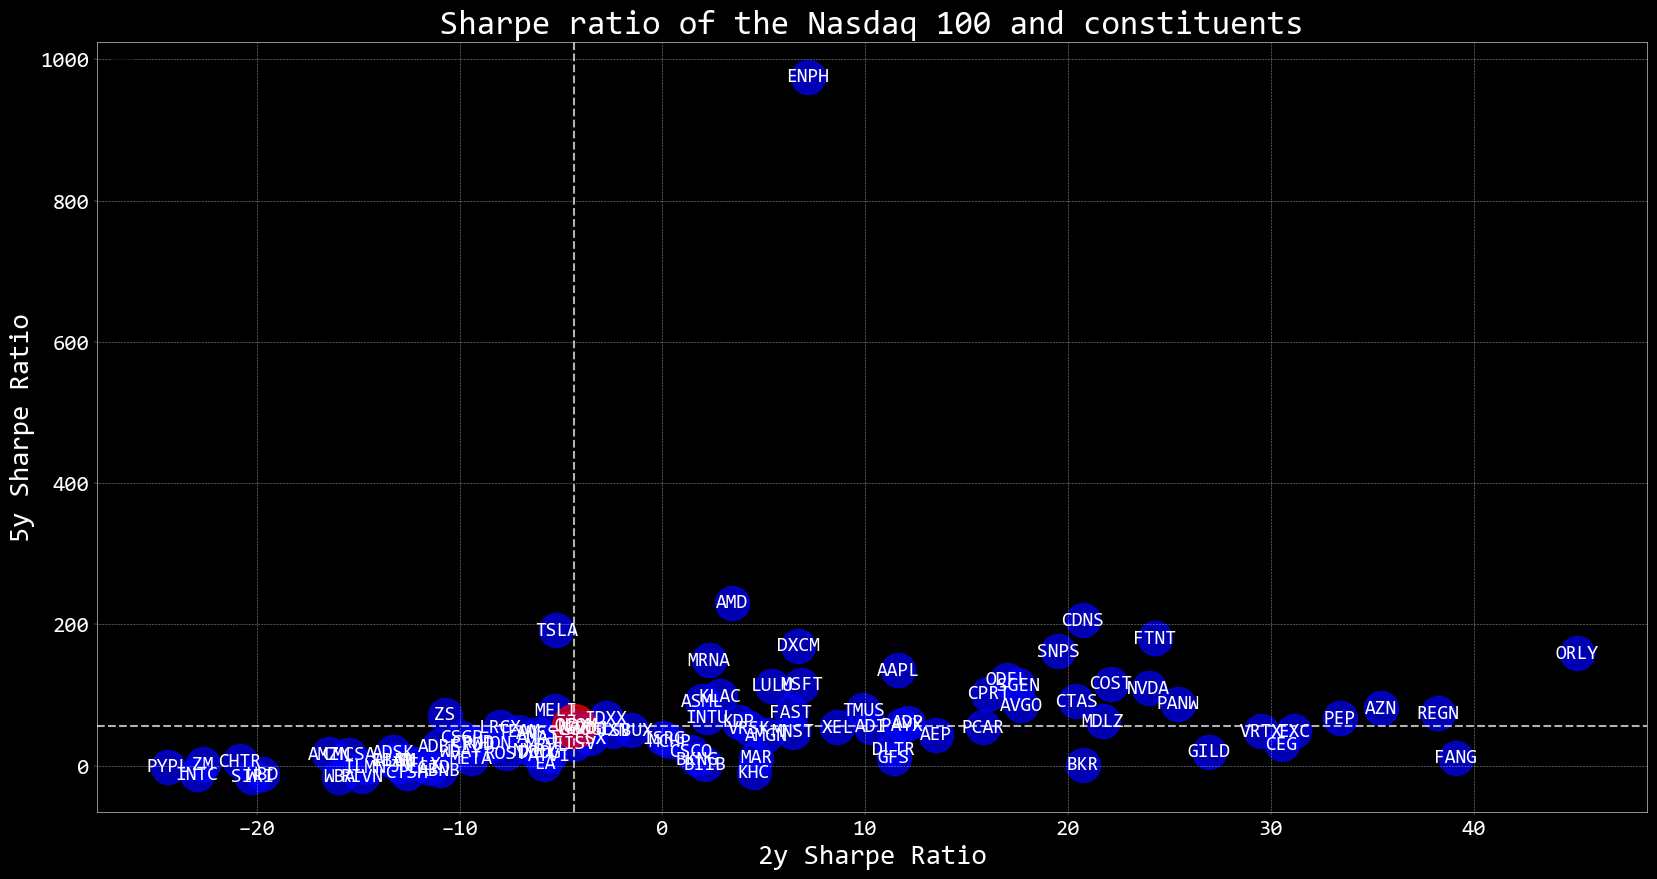

In [6]:
# Set the background color to black
plt.style.use('dark_background')

# Create a scatter plot of the 2y and 5y risk adjusted returns for each stock and for the index
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(constituents_sharpe['2y Sharpe Ratio'], constituents_sharpe['5y Sharpe Ratio'], color='b', s=600, alpha=0.7)
ax.scatter(index_sharpe['2y Sharpe Ratio'], index_sharpe['5y Sharpe Ratio'], color='r', s=1000, alpha=0.7)

# Add ticker labels for each point in constituents_sharpe DataFrame
for i, ticker in enumerate(constituents_sharpe.index):
    ax.annotate(ticker, (constituents_sharpe['2y Sharpe Ratio'][i], constituents_sharpe['5y Sharpe Ratio'][i]), fontsize=14, color='white', ha='center', va='center')

# Add ticker label for the index
ax.text(index_sharpe['2y Sharpe Ratio'], index_sharpe['5y Sharpe Ratio'], 'NDX', fontsize=14, color='white', ha='center', va='center')

# Add vertical and horizontal lines for the index observation
ax.axvline(index_sharpe['2y Sharpe Ratio'], color='w', linestyle='--', alpha=0.7)
ax.axhline(index_sharpe['5y Sharpe Ratio'], color='w', linestyle='--', alpha=0.7)

# Add labels and legend
ax.set_xlabel('2y Sharpe Ratio', fontsize=20)
ax.set_ylabel('5y Sharpe Ratio', fontsize=20)
ax.legend(fontsize=20)

# Move y-axis scale to the left
ax.yaxis.tick_left()

# Set font size of axes and legends
ax.tick_params(axis='both', labelsize=16)

# Set title
plt.title('Sharpe ratio of the Nasdaq 100 and constituents', loc='center', fontsize=24)

# Show the plot
plt.show()


We can see than Enphase Energy is an outlier, with a 5 year return of more than 49x. We can zoom in all the others to visualize it better.

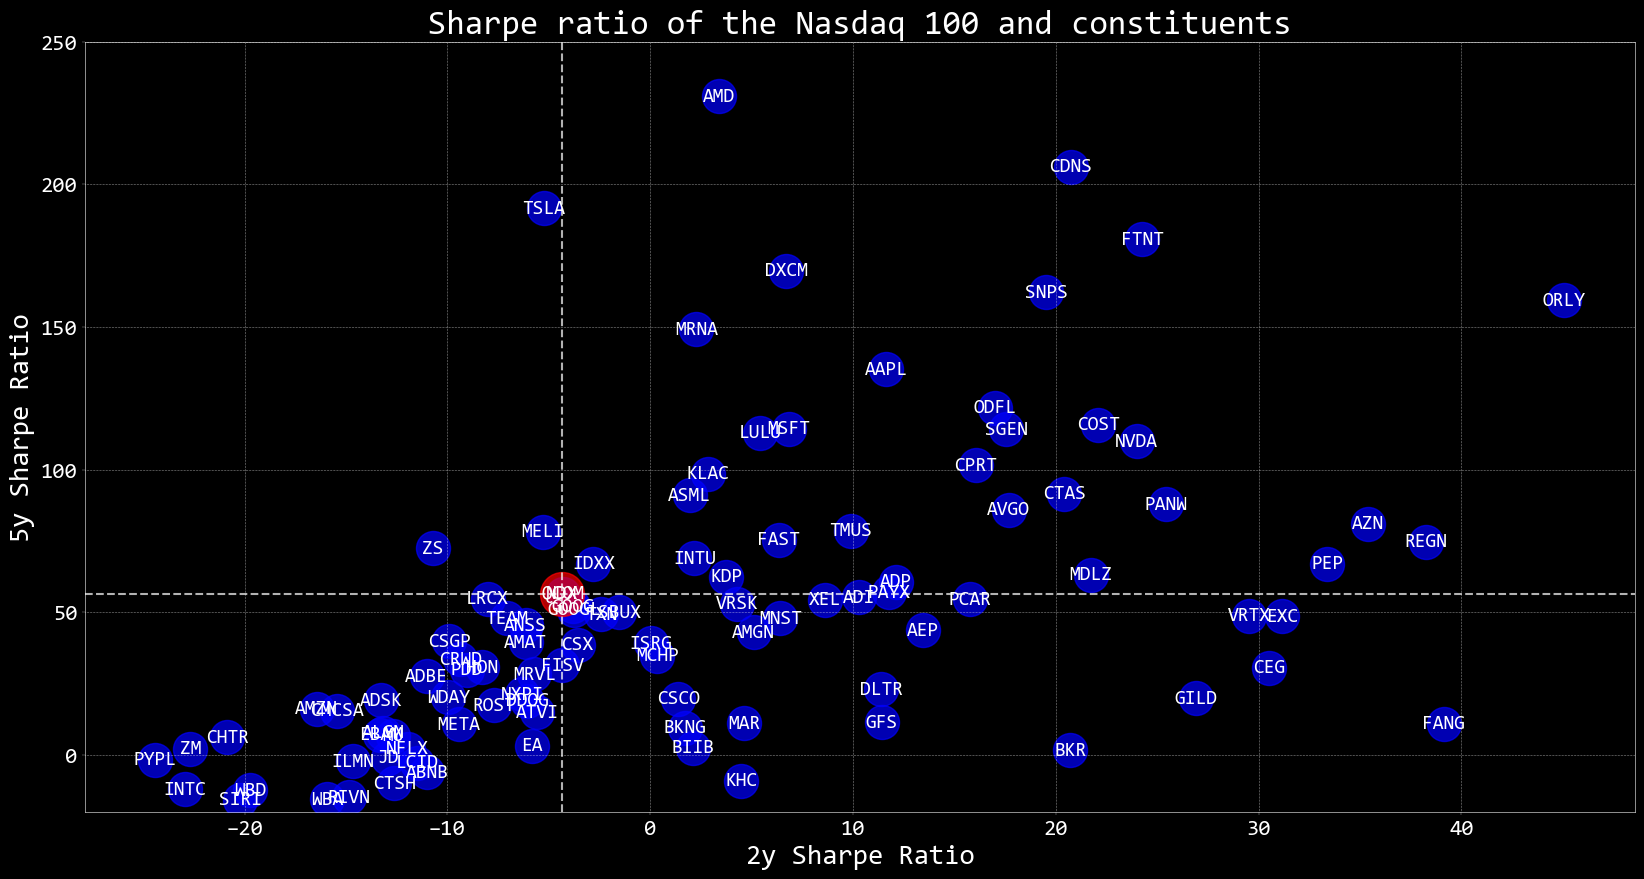

In [7]:
# Set the background color to black
plt.style.use('dark_background')

# Create a scatter plot of the 2y and 5y risk adjusted returns for each stock and for the index
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(constituents_sharpe['2y Sharpe Ratio'], constituents_sharpe['5y Sharpe Ratio'], color='b', s=600, alpha=0.7)
ax.scatter(index_sharpe['2y Sharpe Ratio'], index_sharpe['5y Sharpe Ratio'], color='r', s=1000, alpha=0.7)

# Add ticker labels for each point in constituents_sharpe DataFrame
for i, ticker in enumerate(constituents_sharpe.index):
    ax.annotate(ticker, (constituents_sharpe['2y Sharpe Ratio'][i], constituents_sharpe['5y Sharpe Ratio'][i]), fontsize=14, color='white', ha='center', va='center')

# Add ticker label for the index
ax.text(index_sharpe['2y Sharpe Ratio'], index_sharpe['5y Sharpe Ratio'], 'NDX', fontsize=14, color='white', ha='center', va='center')

# Add vertical and horizontal lines for the index observation
ax.axvline(index_sharpe['2y Sharpe Ratio'], color='w', linestyle='--', alpha=0.7)
ax.axhline(index_sharpe['5y Sharpe Ratio'], color='w', linestyle='--', alpha=0.7)

# Add labels and legend
ax.set_xlabel('2y Sharpe Ratio', fontsize=20)
ax.set_ylabel('5y Sharpe Ratio', fontsize=20)
ax.legend(fontsize=20)

# Move y-axis scale to the left
ax.yaxis.tick_left()
ax.set_ylim([-20, 250])

# Set font size of axes and legends
ax.tick_params(axis='both', labelsize=16)

# Set title
plt.title('Sharpe ratio of the Nasdaq 100 and constituents', loc='center', fontsize=24)

# Show the plot
plt.show()


In [8]:
# Create a function to assign a quadrant based on the sharpe ratios
def assign_quadrant(row):
    if row['2y Sharpe Ratio'] >= index_sharpe['2y Sharpe Ratio'] and row['5y Sharpe Ratio'] >= index_sharpe['5y Sharpe Ratio']:
        return 1
    elif row['2y Sharpe Ratio'] >= index_sharpe['2y Sharpe Ratio'] and row['5y Sharpe Ratio'] < index_sharpe['5y Sharpe Ratio']:
        return 2
    elif row['2y Sharpe Ratio'] < index_sharpe['2y Sharpe Ratio'] and row['5y Sharpe Ratio'] >= index_sharpe['5y Sharpe Ratio']:
        return 3
    else:
        return 4

    
# Apply the function to create a new column 'Quadrant'
constituents_sharpe['Quadrant'] = constituents_sharpe.apply(assign_quadrant, axis=1)

## Getting fundamental data

In [9]:
# Get stock data from finviz
metrics = {}

for ticker in constituents_sharpe.index:
    stock = finvizfinance(ticker)
    metric = stock.ticker_fundament()
    metrics[ticker] = metric

df = pd.DataFrame.from_dict(metrics, orient='index')
df.head()

,Company,Sector,Industry,Country,Index,P/E,EPS (ttm),Insider Own,Shs Outstand,Perf Week,...,Earnings,Payout,Avg Volume,Price,Recom,SMA20,SMA50,SMA200,Volume,Change
MSFT,Microsoft Corporation,Technology,Software - Infrastructure,USA,"DJIA, NDX, S&P 500",31.52,8.99,0.06%,7.45B,-1.28%,...,Jan 24 AMC,28.10%,31.80M,283.49,1.90,1.51%,6.72%,11.47%,"27,403,432",0.23%
AAPL,Apple Inc.,Technology,Consumer Electronics,USA,"DJIA, NDX, S&P 500",27.20,5.89,0.07%,15.89B,-3.34%,...,May 04 AMC,15.40%,65.11M,160.10,2.00,0.15%,3.92%,7.18%,"50,133,064",-0.44%
AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,USA,"NDX, S&P 500",-,-0.27,9.80%,10.22B,-5.89%,...,Feb 02 AMC,-,64.79M,97.83,1.80,-1.99%,-0.60%,-8.85%,"56,735,008",-2.09%
NVDA,NVIDIA Corporation,Technology,Semiconductors,USA,"NDX, S&P 500",152.18,1.74,0.40%,2.46B,-3.49%,...,Feb 22 AMC,9.10%,50.05M,264.95,2.10,-0.26%,10.48%,50.44%,"44,625,896",-2.48%
GOOGL,Alphabet Inc.,Communication Services,Internet Content & Information,USA,"NDX, S&P 500",23.32,4.49,0.28%,6.84B,-0.08%,...,Feb 02 AMC,0.00%,40.03M,104.64,1.80,1.80%,6.41%,3.44%,"24,370,274",-0.67%


## Merging and cleaning the data

In [10]:
# Merge data
stocks = pd.concat([df, constituents_sharpe], axis=1)
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, MSFT to RIVN
Data columns (total 85 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company                101 non-null    object 
 1   Sector                 101 non-null    object 
 2   Industry               101 non-null    object 
 3   Country                101 non-null    object 
 4   Index                  101 non-null    object 
 5   P/E                    101 non-null    object 
 6   EPS (ttm)              101 non-null    object 
 7   Insider Own            101 non-null    object 
 8   Shs Outstand           101 non-null    object 
 9   Perf Week              101 non-null    object 
 10  Market Cap             101 non-null    object 
 11  Forward P/E            101 non-null    object 
 12  EPS next Y             101 non-null    object 
 13  Insider Trans          101 non-null    object 
 14  Shs Float              101 non-null    object 
 15  Perf Mo

In [11]:
# Replace '-' with null values and convert to number
stocks.replace('-', np.nan, inplace=True)
stocks = stocks.apply(pd.to_numeric, errors='ignore')

# Convert short ratio
stocks['Short Float / Ratio'] = stocks['Short Float / Ratio'].str.split('%').str[0].astype(float) / 100

# Clean columns with percentage signs
def clean_percentage_column(col):
    if col.dtype == 'object' and '%' in col.iloc[0]:
        return col.str.replace('%', '').astype(float) / 100
    else:
        return col

stocks = stocks.apply(clean_percentage_column)

# Convert to billions all columns displayed as strings
cols_to_transform = []
for col_name in stocks.columns:
    col = stocks[col_name]
    if col.dtype == 'object' and col.iloc[0][-1] in ('B', 'M'):
        cols_to_transform.append(col_name)

def convert_to_billion(x):
    if isinstance(x, str) and x[-1] == 'B':
        return round(float(x[:-1]), 2)
    elif isinstance(x, str) and x[-1] == 'M':
        return round(float(x[:-1])/1000, 2)
    elif isinstance(x, str) and x[-1] == 'K':
        return round(float(x[:-1])/1000000, 2)
    else:
        return x

for col in cols_to_transform:
    stocks[col] = stocks[col].apply(convert_to_billion)
    
# Remove commas and convert to number
stocks['Volume'] = stocks['Volume'].str.replace(',', '').astype(int)

# Remove columns with zero variance
print(stocks[['Shortable', 'Optionable']].value_counts())
stocks = stocks.drop(['Shortable', 'Optionable'], axis=1)

# Convert Earnings column to datetime
stocks['Earnings'] = pd.to_datetime(stocks['Earnings'].str.replace('AMC', '16:00').str.replace('BMO', '9:30'), 
                                    format='%b %d %H:%M')

Shortable  Optionable
Yes        Yes           101
dtype: int64


In [12]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, MSFT to RIVN
Data columns (total 83 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Company                101 non-null    object        
 1   Sector                 101 non-null    object        
 2   Industry               101 non-null    object        
 3   Country                101 non-null    object        
 4   Index                  101 non-null    object        
 5   P/E                    84 non-null     float64       
 6   EPS (ttm)              101 non-null    float64       
 7   Insider Own            99 non-null     float64       
 8   Shs Outstand           101 non-null    float64       
 9   Perf Week              101 non-null    float64       
 10  Market Cap             101 non-null    float64       
 11  Forward P/E            97 non-null     float64       
 12  EPS next Y             101 non-null    float64       
 13  Inside

## Exploring the data

In [13]:
stocks.Quadrant.value_counts()

4    37
1    33
2    28
3     3
Name: Quadrant, dtype: int64

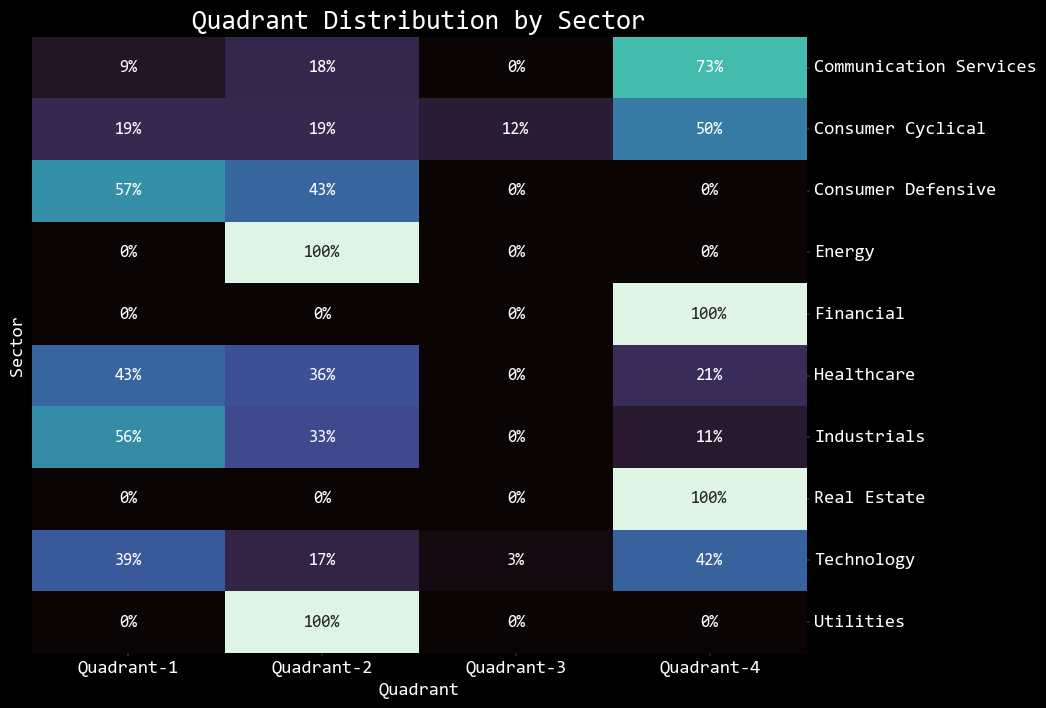

In [14]:
quadrant_sector = stocks.groupby('Sector').Quadrant.value_counts(normalize=True).to_frame()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(quadrant_sector.unstack().fillna(0), annot=True, fmt='.0%', cbar=False, annot_kws={'fontsize': 12}, cmap='mako')
plt.xlabel('Quadrant')
plt.title('Quadrant Distribution by Sector', loc='center')
plt.show()

In [15]:
# Summarize fundamental data for Technology sector
quadrant_tech = round(stocks.loc[stocks['Sector'] == 'Technology'].groupby('Quadrant')
                      [["Market Cap", "P/E", "Forward P/E", 'P/S', 'P/B', 'P/FCF', 
                        'ROE', 'ROA', 'Profit Margin', 'Dividend %',
                        'Sales past 5Y', 'EPS past 5Y', 'EPS next 5Y']].median().fillna(0),2)

quadrant_tech_styler = quadrant_tech.style.background_gradient()

summary_styler = quadrant_tech.agg(["median", "mean"], axis=0).style \
                   .format(precision=2) \
                   .relabel_index(["Median", "Average"]) \
                   .set_properties(**{"font-weight": "bold"})

quadrant_tech_styler.format(precision=2).concat(summary_styler)

,Market Cap,P/E,Forward P/E,P/S,P/B,P/FCF,ROE,ROA,Profit Margin,Dividend %,Sales past 5Y,EPS past 5Y,EPS next 5Y
Quadrant,,,,,,,,,,,,,
1,127.06,62.54,26.78,9.90,20.09,36.94,0.35,0.16,0.22,0.01,0.19,0.27,0.16
2,83.92,23.24,15.41,4.93,4.30,22.77,0.22,0.10,0.24,0.02,0.15,0.18,0.09
3,15.00,0.00,53.47,11.13,28.93,49.09,-0.63,-0.12,-0.24,0.00,0.54,-0.48,0.60
4,41.53,16.41,21.01,5.82,7.13,30.41,0.08,0.05,0.12,0.01,0.19,0.18,0.14
Median,62.73,19.82,23.90,7.86,13.61,33.67,0.15,0.08,0.17,0.01,0.19,0.18,0.15
Average,66.88,25.55,29.17,7.95,15.11,34.80,0.00,0.05,0.08,0.01,0.27,0.04,0.25


In [16]:
# Quadrant distribution by Industry for the Technology Sector
quadrant_tech_industry = round(stocks.loc[stocks['Sector'] == 'Technology'].groupby('Industry').
                               Quadrant.value_counts().unstack().fillna(0),0)

quadrant_tech_industry.style.background_gradient().format(precision=0)

Quadrant,1,2,3,4
Industry,,,,
Communication Equipment,0,1,0,0
Consumer Electronics,1,0,0,0
Information Technology Services,0,1,0,1
Semiconductor Equipment & Materials,2,0,0,2
Semiconductors,4,4,0,4
Software - Application,2,0,0,6
Software - Infrastructure,4,0,1,2
Solar,1,0,0,0


The main difference between the first and last quadrant for Technology stocks seems to be profitability. ROE, ROA and Profit Margin show a big difference between quadrants 1 and 4, and this also reflects in a richer valuation for the more profitable quadrant. On the other hand, stocks in quadrant 2 (the ones that outperformed last 2 years but not on a 5 year period) show good profitability but lower expected growth and valuation.

When it comes to industry distribution, Information Technology Services and Software - Application are the ones that show greater underperformance, while Consumer Electronics, Software - Infrastructure, and Solar are more tilted towards the first quadrant.

## Analyzing risk adjusted returns

Text(0.0, 1.0, 'Absolute Correlation coefficients')

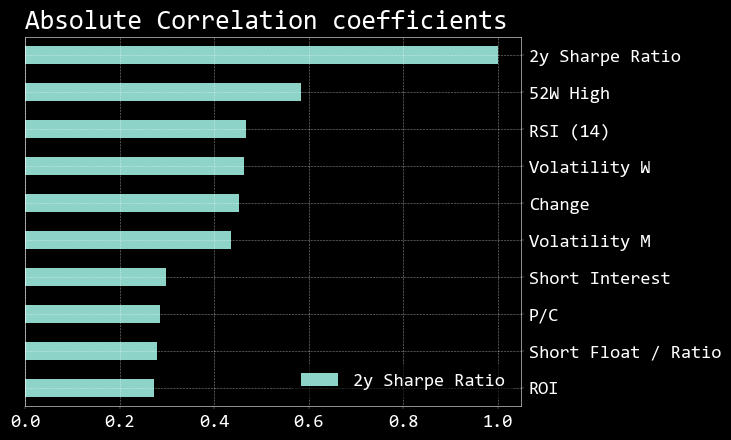

In [17]:
# Calculate correlation (on an absolute basis) for the 2y risk adjusted return
correlations_2y = stocks.drop(['Perf Week', 'Perf Month', 'Perf Quarter', 'Perf Half Y', 'Perf Year', 
                               'Perf YTD', 'SMA20', 'SMA50', 'SMA200', 
                               '5y Return', '5y Std', '2y Return', '2y Std', '5y Sharpe Ratio', 'Quadrant'], axis=1)

abs(correlations_2y.corr(numeric_only=True)['2y Sharpe Ratio']).sort_values(ascending=False).to_frame().head(10).sort_values(by='2y Sharpe Ratio', ascending=True).plot(kind='barh')
plt.title('Absolute Correlation coefficients')

Text(0.0, 1.0, 'Absolute Correlation coefficients')

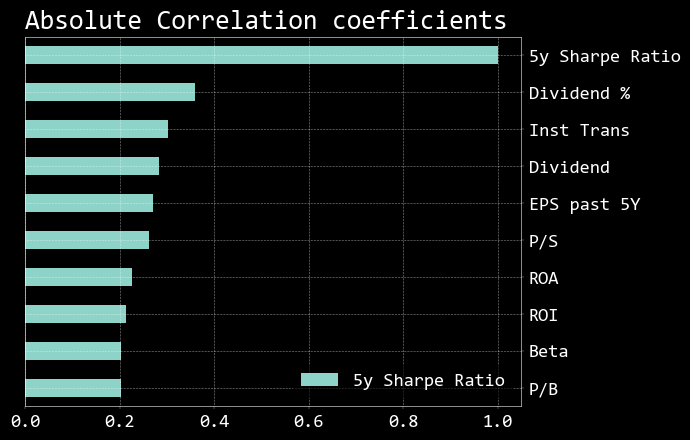

In [18]:
# Calculate correlation (on an absolute basis) for the 5y risk adjusted return
correlations_5y = stocks.drop(['Perf Week', 'Perf Month', 'Perf Quarter', 'Perf Half Y', 'Perf Year', 
                               'Perf YTD', 'SMA20', 'SMA50', 'SMA200',  
                               '5y Return', '5y Std', '2y Return', '2y Std', '2y Sharpe Ratio', 'Quadrant'], axis=1)

abs(correlations_5y.corr(numeric_only=True)['5y Sharpe Ratio']).sort_values(ascending=False).to_frame().head(10).sort_values(by='5y Sharpe Ratio', ascending=True).plot(kind='barh')
plt.title('Absolute Correlation coefficients')

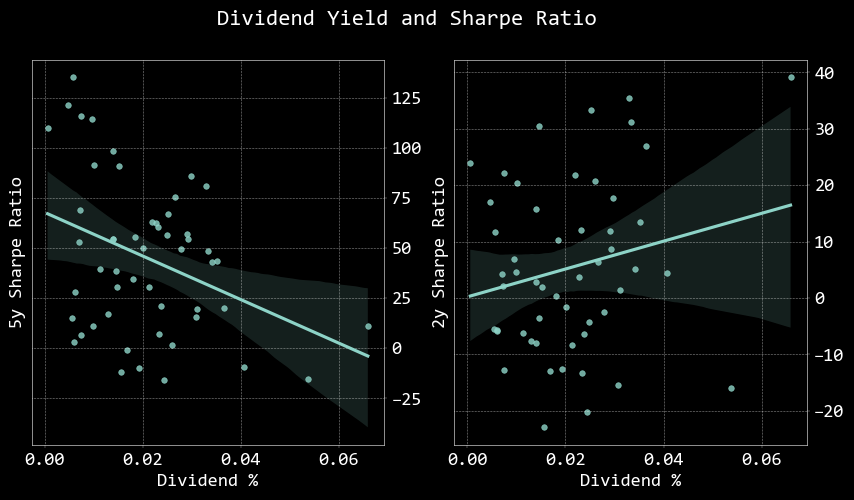

In [19]:
# Create two separate plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 5y Sharpe Ratio vs Dividend %
sns.regplot(x='Dividend %', y='5y Sharpe Ratio', data=stocks, ax=axes[0])
axes[0].set_xlabel('Dividend %')
axes[0].set_ylabel('5y Sharpe Ratio')

# Plot 2y Sharpe Ratio vs Dividend %
sns.regplot(x='Dividend %', y='2y Sharpe Ratio', data=stocks, ax=axes[1])
axes[1].set_xlabel('Dividend %')
axes[1].set_ylabel('2y Sharpe Ratio')

# Figure title
fig.suptitle('Dividend Yield and Sharpe Ratio', fontsize=16)

# Display the plot
plt.show()

Dividend yield seems to be an important factor in determinining risk adjusted performance for the last 2 years, while for the 5 year period, higher dividend payers show weaker risk adjusted returns.

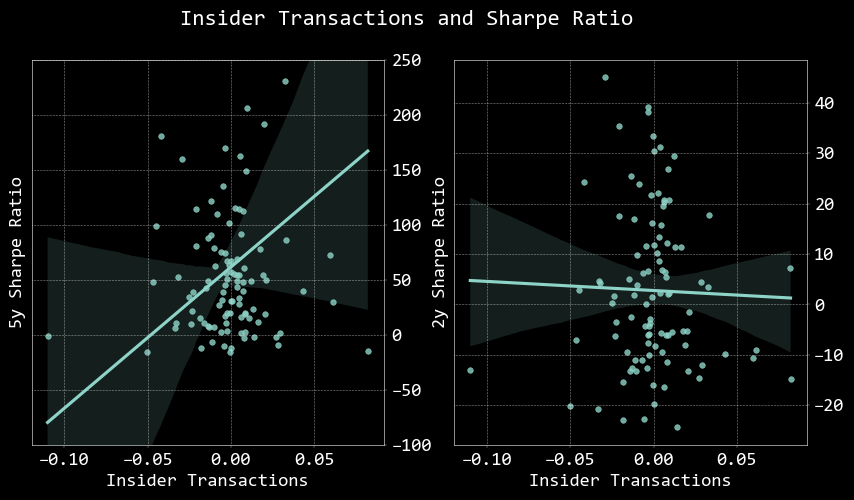

In [20]:
# Create two separate plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 5y Sharpe Ratio vs Dividend %
sns.regplot(x='Inst Trans', y='5y Sharpe Ratio', data=stocks, ax=axes[0])
axes[0].set_xlabel('Insider Transactions')
axes[0].set_ylabel('5y Sharpe Ratio')
axes[0].set_ylim([-100,250])

# Plot 2y Sharpe Ratio vs Dividend %
sns.regplot(x='Inst Trans', y='2y Sharpe Ratio', data=stocks, ax=axes[1])
axes[1].set_xlabel('Insider Transactions')
axes[1].set_ylabel('2y Sharpe Ratio')

# Figure title
fig.suptitle('Insider Transactions and Sharpe Ratio', fontsize=16)

# Display the plot
plt.show()

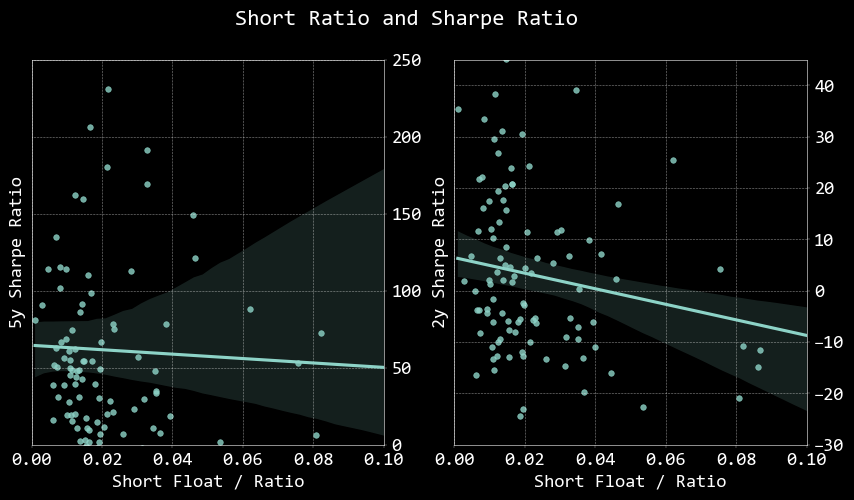

In [21]:
# Create two separate plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 5y Sharpe Ratio vs Dividend %
sns.regplot(x='Short Float / Ratio', y='5y Sharpe Ratio', data=stocks, ax=axes[0])
axes[0].set_xlabel('Short Float / Ratio')
axes[0].set_ylabel('5y Sharpe Ratio')
axes[0].set_ylim([0,250])
axes[0].set_xlim([0,0.10])

# Plot 2y Sharpe Ratio vs Dividend %
sns.regplot(x='Short Float / Ratio', y='2y Sharpe Ratio', data=stocks, ax=axes[1])
axes[1].set_xlabel('Short Float / Ratio')
axes[1].set_ylabel('2y Sharpe Ratio')
axes[1].set_ylim([-30,45])
axes[1].set_xlim([0,0.10])

# Figure title
fig.suptitle('Short Ratio and Sharpe Ratio', fontsize=16)

# Display the plot
plt.show()

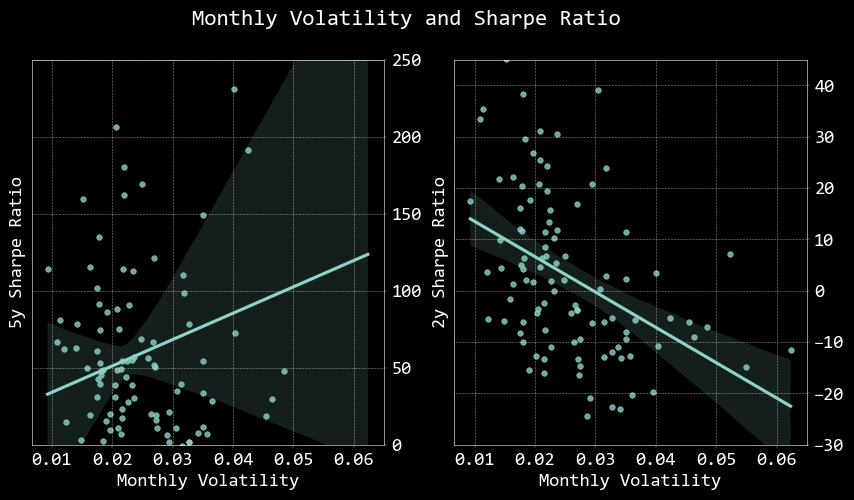

In [22]:
# Create two separate plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 5y Sharpe Ratio vs Dividend %
sns.regplot(x='Volatility M', y='5y Sharpe Ratio', data=stocks, ax=axes[0])
axes[0].set_xlabel('Monthly Volatility')
axes[0].set_ylabel('5y Sharpe Ratio')
axes[0].set_ylim([0,250])

# Plot 2y Sharpe Ratio vs Dividend %
sns.regplot(x='Volatility M', y='2y Sharpe Ratio', data=stocks, ax=axes[1])
axes[1].set_xlabel('Monthly Volatility')
axes[1].set_ylabel('2y Sharpe Ratio')
axes[1].set_ylim([-30,45])

# Figure title
fig.suptitle('Monthly Volatility and Sharpe Ratio', fontsize=16)

# Display the plot
plt.show()

Monthly volatility seems to be another determinant of relative performance. For the last two years, higher volatility stocks have underperformed on a relative basis, while for the longer term period higher volatility is associated with higher risk adjusted returns.

In [23]:
# Calculate fundamental data for different quadrants
quadrant_fund = round(stocks.groupby('Quadrant')[["Market Cap", "P/E", "Forward P/E", 'P/S', 'P/B', 'P/FCF',
                                                  'ROE', 'ROA', 'Profit Margin', 'Dividend %',
                                                  'Sales past 5Y', 'EPS past 5Y', 'EPS next 5Y']].median().fillna(0),2)

quadrant_fund_styler = quadrant_fund.style.background_gradient()

summary_styler = quadrant_fund.agg(["median", "mean"], axis=0).style \
                   .format(precision=2) \
                   .relabel_index(["Median", "Average"]) \
                   .set_properties(**{"font-weight": "bold"})

quadrant_fund_styler.format(precision=2).concat(summary_styler)

,Market Cap,P/E,Forward P/E,P/S,P/B,P/FCF,ROE,ROA,Profit Margin,Dividend %,Sales past 5Y,EPS past 5Y,EPS next 5Y
Quadrant,,,,,,,,,,,,,
1,58.61,35.89,25.64,6.50,11.50,46.86,0.29,0.15,0.18,0.02,0.15,0.22,0.13
2,52.40,22.24,17.17,4.03,4.29,23.04,0.22,0.10,0.18,0.03,0.06,0.08,0.10
3,63.38,90.32,52.35,7.03,28.93,38.91,0.29,0.04,0.05,0.00,0.54,0.40,0.45
4,41.53,32.82,18.78,4.48,5.20,30.41,0.08,0.05,0.10,0.02,0.16,0.10,0.12
Median,55.50,34.36,22.21,5.49,8.35,34.66,0.26,0.08,0.14,0.02,0.15,0.16,0.12
Average,53.98,45.32,28.48,5.51,12.48,34.80,0.22,0.08,0.13,0.02,0.23,0.20,0.20


Quadrant 1 shows the higher mix between profitability and growth, which reflects in a relatively higher valuation. Quadrant 2 shows high profitability but low growth. Quadrants 3 and 4 show high growth but low profitability, but with an important distinction: the highest growing stocks have underperformed for the past 2 years, but have outperformed for the past 5 (Tesla, Mercadolibre and Zscaler). 

In [24]:
# Summarize fundamental data by sector
sector_fund = round(stocks.groupby('Sector')[["Market Cap", "P/E", "Forward P/E", 'P/S', 'P/B', 'P/FCF',
                                              'ROE', 'ROA', 'Profit Margin', 'Dividend %',
                                              'Sales past 5Y', 'EPS past 5Y', 'EPS next 5Y']].median().fillna(0), 2)

sector_fund_styler = sector_fund.style.background_gradient()

summary_styler = quadrant_fund.agg(["median", "mean"], axis=0).style \
                   .format(precision=2) \
                   .relabel_index(["Median", "Average"]) \
                   .set_properties(**{"font-weight": "bold"})

sector_fund_styler.format(precision=2).concat(summary_styler)

,Market Cap,P/E,Forward P/E,P/S,P/B,P/FCF,ROE,ROA,Profit Margin,Dividend %,Sales past 5Y,EPS past 5Y,EPS next 5Y
Sector,,,,,,,,,,,,,
Communication Services,148.74,28.60,17.21,4.58,4.55,29.93,0.11,0.07,0.14,0.02,0.13,0.10,0.12
Consumer Cyclical,56.84,35.28,23.63,5.08,7.56,23.70,0.26,0.11,0.11,0.02,0.21,0.22,0.20
Consumer Defensive,55.07,34.93,20.43,2.90,3.79,56.53,0.17,0.07,0.09,0.02,0.06,0.05,0.07
Energy,28.62,5.86,10.34,2.12,1.88,90.03,0.14,0.08,0.21,0.05,0.28,0.15,0.24
Financial,81.66,35.08,13.11,2.97,4.13,15.99,0.12,0.03,0.09,0.00,0.16,0.05,0.15
Healthcare,51.56,25.46,19.62,7.02,6.10,44.18,0.18,0.09,0.18,0.04,0.15,0.04,0.11
Industrials,39.01,27.84,23.92,5.11,10.27,53.42,0.36,0.12,0.20,0.01,0.08,0.14,0.09
Real Estate,27.65,73.99,49.31,12.67,4.03,62.36,0.06,0.05,0.17,0.00,0.18,0.22,0.20
Technology,58.76,29.30,22.16,7.83,8.84,33.87,0.18,0.10,0.18,0.02,0.19,0.22,0.14


Energy seems to be the sector showing the lowest valuation but still high profitability. It's interesting to note that the Consumer Defensive sector has a similar valuation than the Technology sector, but way lower expected growth and also lower profitabilty. 

In [25]:
# Fundamental data for best performing individual stocks
best_quadrant = round(stocks[["Market Cap", "P/E", "Forward P/E", 'P/S', 'P/B', 'P/FCF',
                              'ROE', 'ROA', 'Profit Margin', 'Dividend %',
                              'Sales past 5Y', 'EPS past 5Y', 'EPS next 5Y']][stocks['Quadrant'] == 1].fillna(0),2)

best_quadrant_styler = best_quadrant.style.background_gradient()

summary_styler = quadrant_fund.agg(["median", "mean"], axis=0).style \
                   .format(precision=2) \
                   .relabel_index(["Median", "Average"]) \
                   .set_properties(**{"font-weight": "bold"})
                   
best_quadrant_styler.format(precision=2).concat(summary_styler)

,Market Cap,P/E,Forward P/E,P/S,P/B,P/FCF,ROE,ROA,Profit Margin,Dividend %,Sales past 5Y,EPS past 5Y,EPS next 5Y
MSFT,2057.70,31.52,26.36,10.08,11.53,50.62,0.39,0.19,0.33,0.01,0.16,0.24,0.12
AAPL,2519.25,27.20,24.26,6.50,44.85,30.49,1.64,0.28,0.25,0.01,0.12,0.22,0.08
NVDA,650.65,152.18,44.06,24.12,29.54,190.81,0.19,0.10,0.16,0.00,0.23,0.09,0.21
AVGO,259.75,20.74,13.95,7.55,11.06,26.87,0.57,0.17,0.37,0.03,0.14,0.46,0.09
PEP,250.46,28.19,23.18,2.90,14.63,0.00,0.49,0.10,0.10,0.03,0.06,0.05,0.07
COST,222.00,35.96,31.23,0.95,9.53,56.53,0.28,0.09,0.03,0.01,0.12,0.17,0.09
TMUS,181.71,64.31,15.49,2.28,2.66,64.64,0.04,0.01,0.03,0.00,0.14,-0.02,0.65
AMD,148.74,104.33,21.22,6.30,2.73,47.75,0.02,0.02,0.06,0.00,0.35,0.22,0.08
QCOM,134.14,11.50,10.53,3.12,7.18,28.13,0.71,0.25,0.27,0.02,0.15,0.47,-0.07
INTU,119.98,63.88,28.01,8.77,7.72,36.87,0.12,0.07,0.14,0.01,0.20,0.14,0.15


Analyzing the best performing stocks, it is clear that high ROE, ROA and Profit Margins are the rule, with positive realized and expected growth.

Text(0.0, 1.0, 'Country distribution')

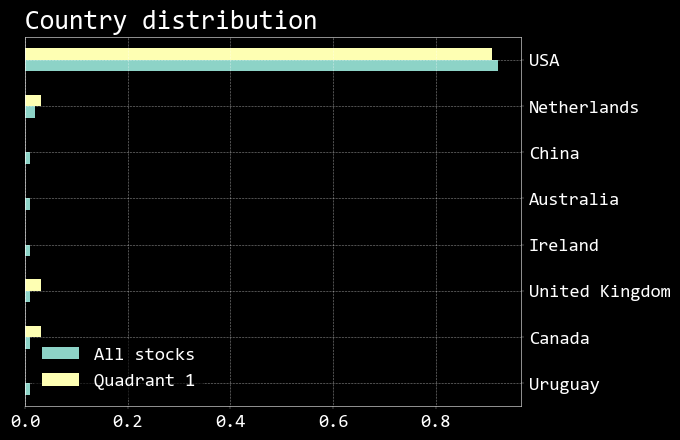

In [26]:
country_dist = pd.concat([stocks['Country'].value_counts(normalize=True), 
                          stocks['Country'][stocks['Quadrant'] == 1].value_counts(normalize=True)], 
                          axis=1).fillna(0)
country_dist.columns = ['All stocks', 'Quadrant 1']

country_dist.sort_values(by='All stocks', ascending=True).plot(kind='barh')
plt.title('Country distribution')


Considering the country distribution is extremely concentrated towards USA, there isn't a difference between Quadrant 1 and the rest of the stocks.

Text(0.0, 1.0, 'Sector distribution')

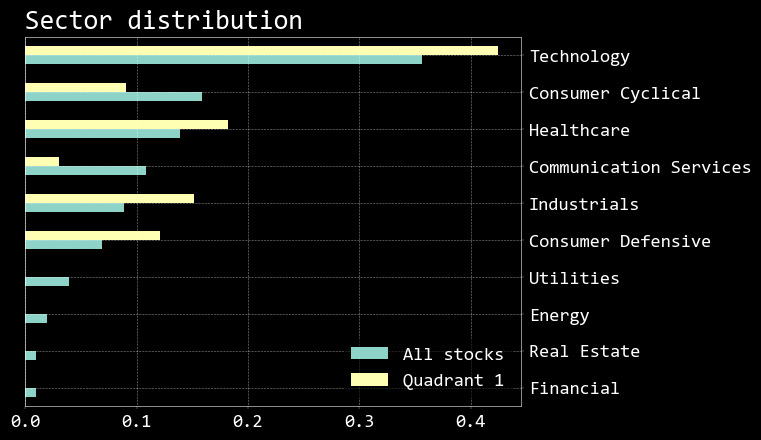

In [27]:
sector_dist = pd.concat([stocks['Sector'].value_counts(normalize=True), 
                          stocks['Sector'][stocks['Quadrant'] == 1].value_counts(normalize=True)], 
                          axis=1).fillna(0)
sector_dist.columns = ['All stocks', 'Quadrant 1']

sector_dist.sort_values(by='All stocks', ascending=True).plot(kind='barh')
plt.title('Sector distribution')

On the other hand, we can see there is a difference in the sector distribution. Quadrant 1 is more tilted towards Technology, Healthcare, Industrials and Consumer Defensive, in detriment of Communication Services and Consumer Cyclical. Lastly, minor sectors are not represented in Quadrant 1, but this could be a consequence of the small sample.